In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from google.colab.patches import cv2_imshow

In [10]:
def show_image(image):
  plt.axis('off')
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()

(4016, 2843, 3)


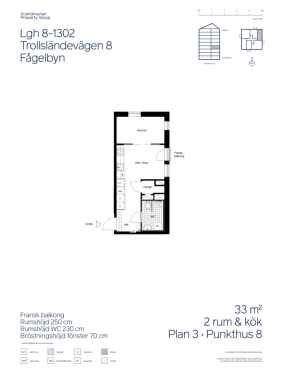

In [11]:
# Read the floorplan image
image = cv2.imread('/content/1617509planritning-8-1302.jpg', cv2.IMREAD_COLOR)

# Print image shape
print(image.shape)

# Show image
show_image(image)

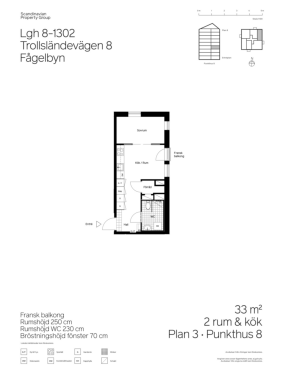

In [12]:
# Convert to gray scale
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
show_image(image_gray)

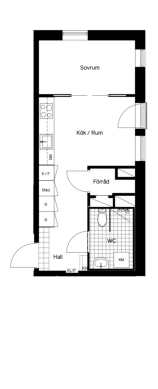

In [13]:
# Crop center of the image
cropped= image[1000:3000, 1000:1750]

# Show image
show_image(cropped)

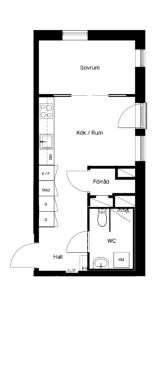

In [14]:
# Apply a threshold to the gray image
ret, thresh1 = cv2.threshold(cropped, 127, 255, cv2.THRESH_BINARY)

# Show image
show_image(thresh1)

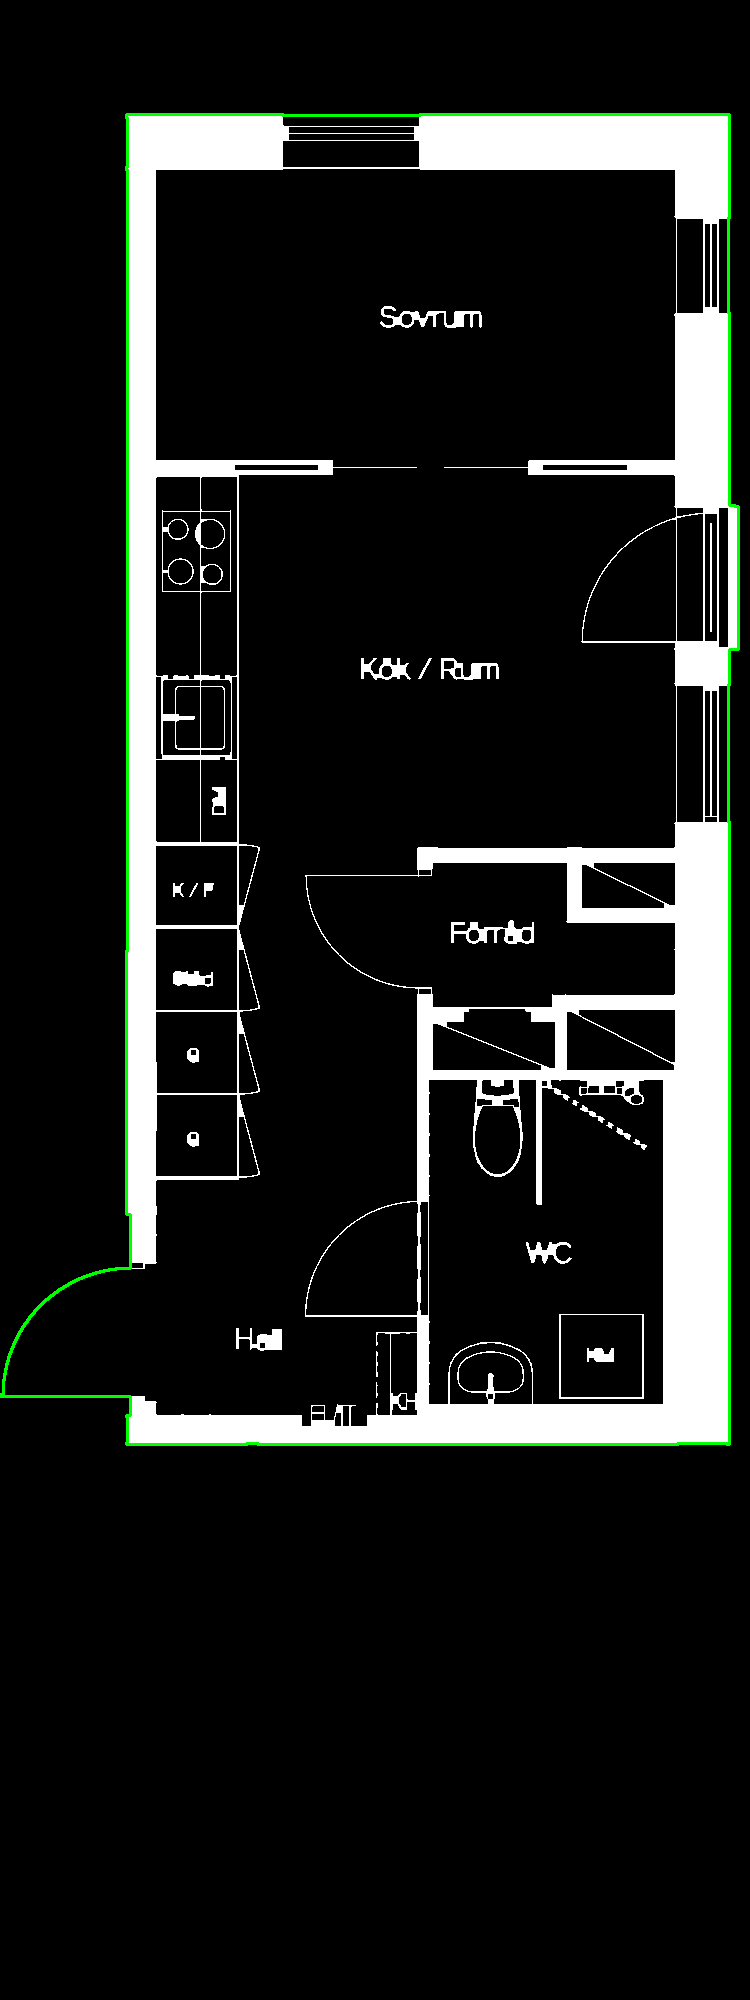

In [15]:
gray = cv2.cvtColor(thresh1, cv2.COLOR_BGR2GRAY)

# 2. Threshold (make sure it's single-channel)
_, thresh = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)

# 3. Morphological closing (optional but often helpful)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# 4. Find contours (closed is CV_8UC1, so no error)
outer_contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. Create a color copy for drawing
result_img = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result_img, outer_contours, -1, (0, 255, 0), 2)

# 6. Show
cv2_imshow(result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


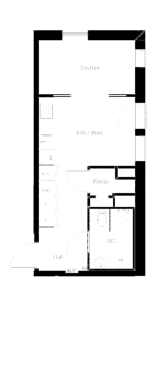

In [16]:
# Apply a bigger threshold to the gray image
ret, thresh2 = cv2.threshold(cropped, 0, 255, cv2.THRESH_BINARY)

# Show image
show_image(thresh2)

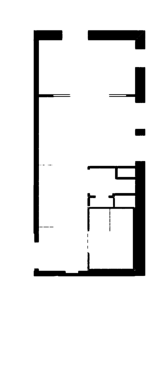

In [17]:
# Apply a median filter to the image so that the gray gets blured and i can remove it
image_cleaned = cv2.medianBlur(thresh2, 5)

show_image(image_cleaned)

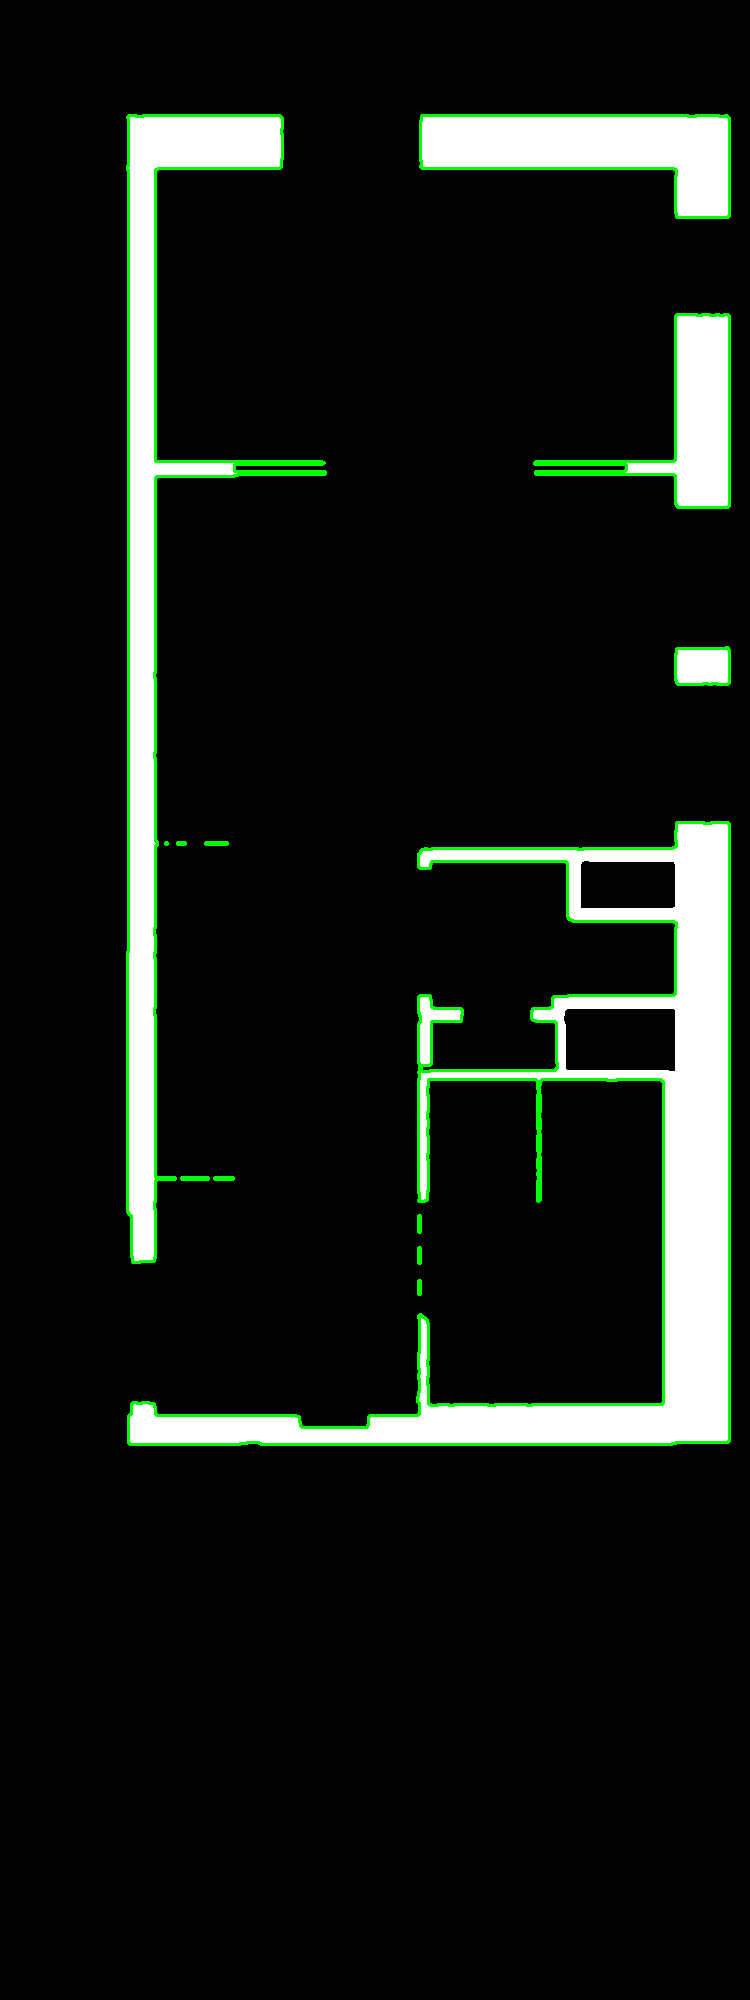

In [18]:
# Get edges of the cleaned image
gray_cleaned = cv2.cvtColor(image_cleaned, cv2.COLOR_BGR2GRAY)
# 2. Threshold (make sure it's single-channel)
_, thresh = cv2.threshold(gray_cleaned, 200, 255, cv2.THRESH_BINARY_INV)

# 3. Morphological closing (optional but often helpful)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# 4. Find contours (closed is CV_8UC1, so no error)
inner_contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 5. Create a color copy for drawing
result_img = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)
cv2.drawContours(result_img, inner_contours, -1, (0, 255, 0), 2)

# 6. Show
cv2_imshow(result_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
# Get countours into segments we can compare

def get_segments_from_contour(contour, epsilon_factor=0.01):
    """
    Approximate the contour with a polygon and return a list of line segments (pairs of points).
    """
    arc_len = cv2.arcLength(contour, True)
    epsilon = epsilon_factor * arc_len
    approx = cv2.approxPolyDP(contour, epsilon, True)
    segments = []
    for i in range(len(approx)):
        p1 = tuple(approx[i][0])
        p2 = tuple(approx[(i+1) % len(approx)][0])
        segments.append((p1, p2))
    return segments

In [20]:
def line_intersection(p1, p2, p3, p4):
    """
    Computes the intersection point (if any) between line segment p1-p2 and p3-p4.
    Returns (x, y) if the segments intersect, otherwise None.
    """
    # Unpack points
    x1, y1 = p1; x2, y2 = p2
    x3, y3 = p3; x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Parallel lines

    # Parameteric intersection (t along p1->p2, u along p3->p4)
    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    if 0 <= t <= 1 and 0 <= u <= 1:
        inter_x = x1 + t * (x2 - x1)
        inter_y = y1 + t * (y2 - y1)
        return (inter_x, inter_y)
    return None

In [21]:
def remove_duplicate_points(points, tol=5):
    """
    Remove points that are closer than tol pixels apart.
    """
    unique = []
    for pt in points:
        if not any(np.linalg.norm(np.array(pt) - np.array(q)) < tol for q in unique):
            unique.append(pt)
    return unique

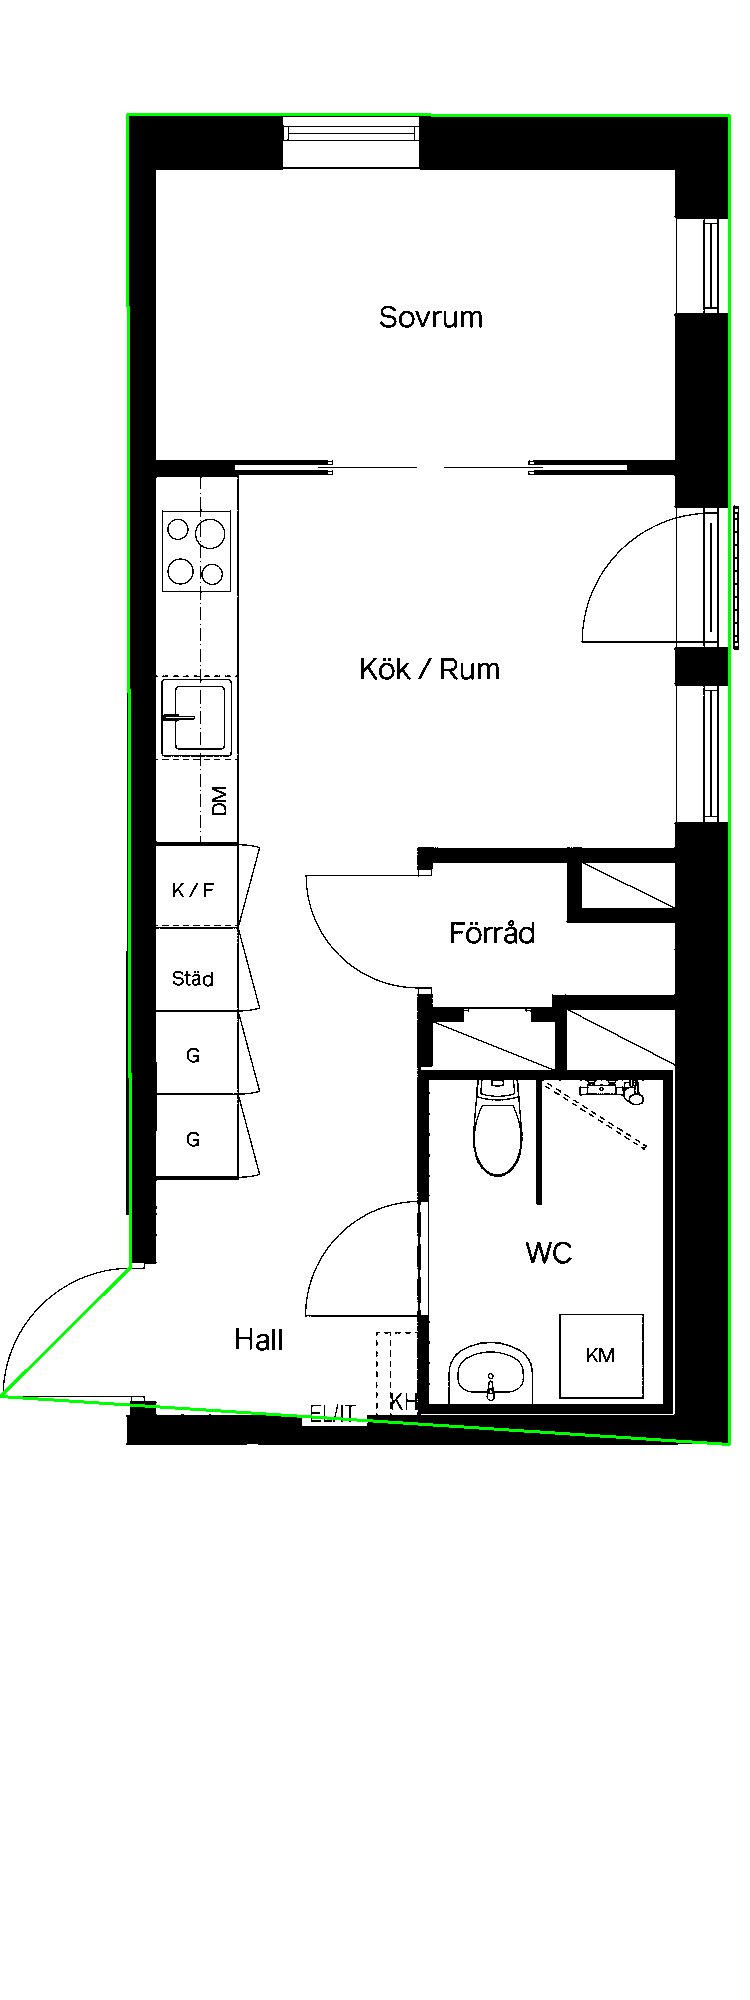

In [22]:
outer_seg_img = thresh1.copy()
for cnt in outer_contours:
    segments = get_segments_from_contour(cnt)
    for seg in segments:
        cv2.line(outer_seg_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 255, 0), 2)
cv2_imshow(outer_seg_img)

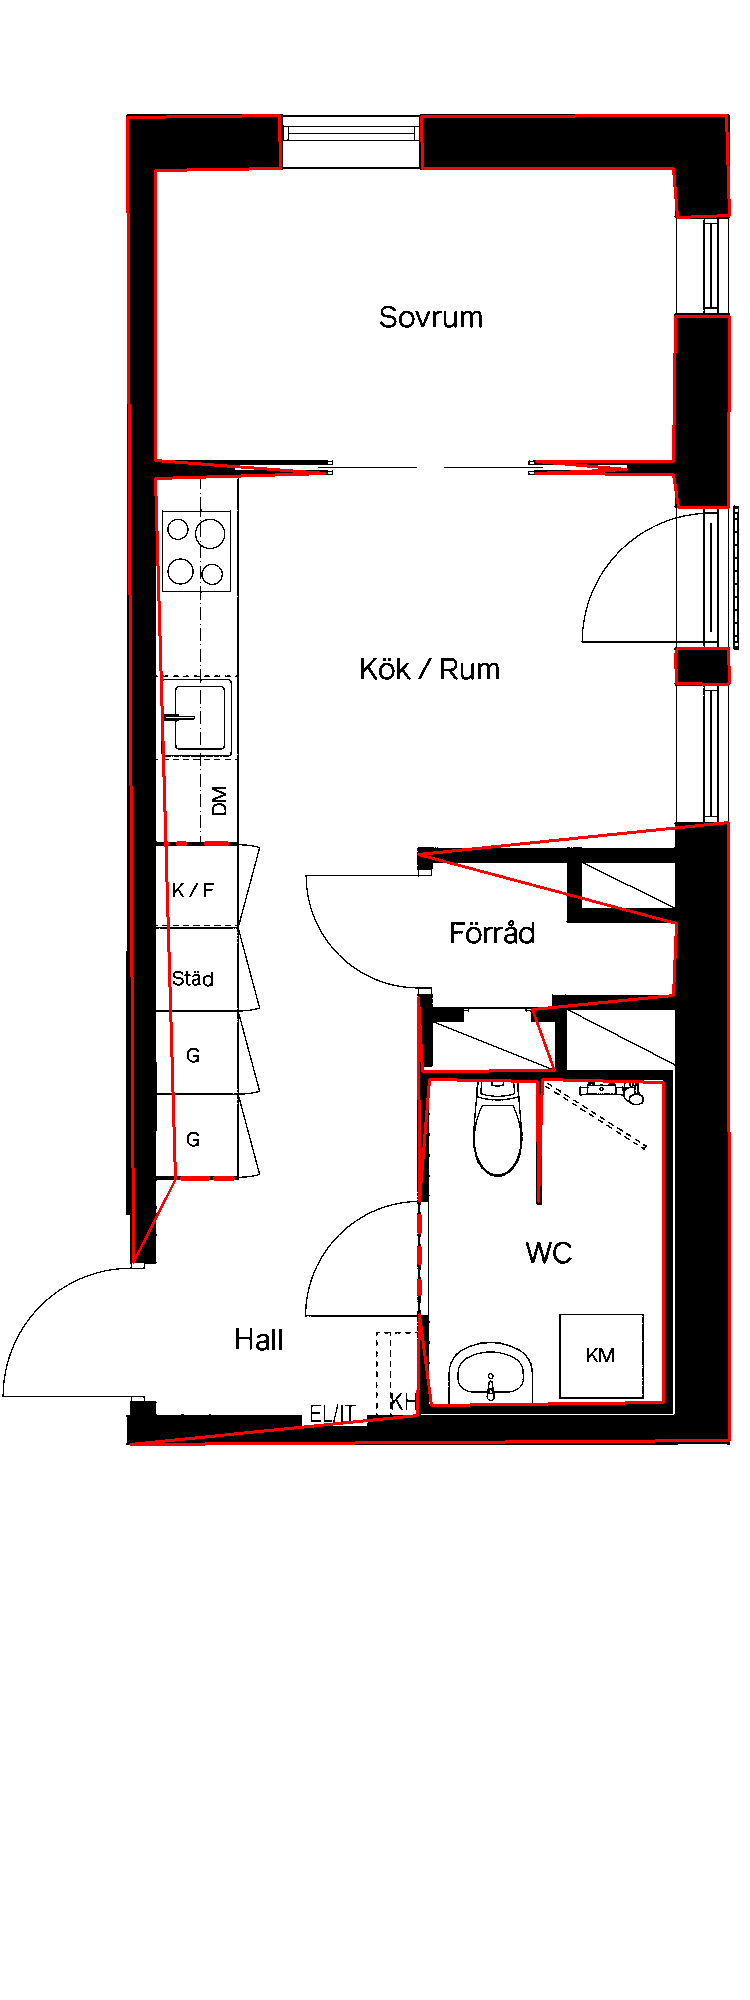

In [23]:
inner_seg_img = thresh1.copy()
for cnt in inner_contours:
    segments = get_segments_from_contour(cnt)
    for seg in segments:
        cv2.line(inner_seg_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 0, 255), 2)
cv2_imshow(inner_seg_img)

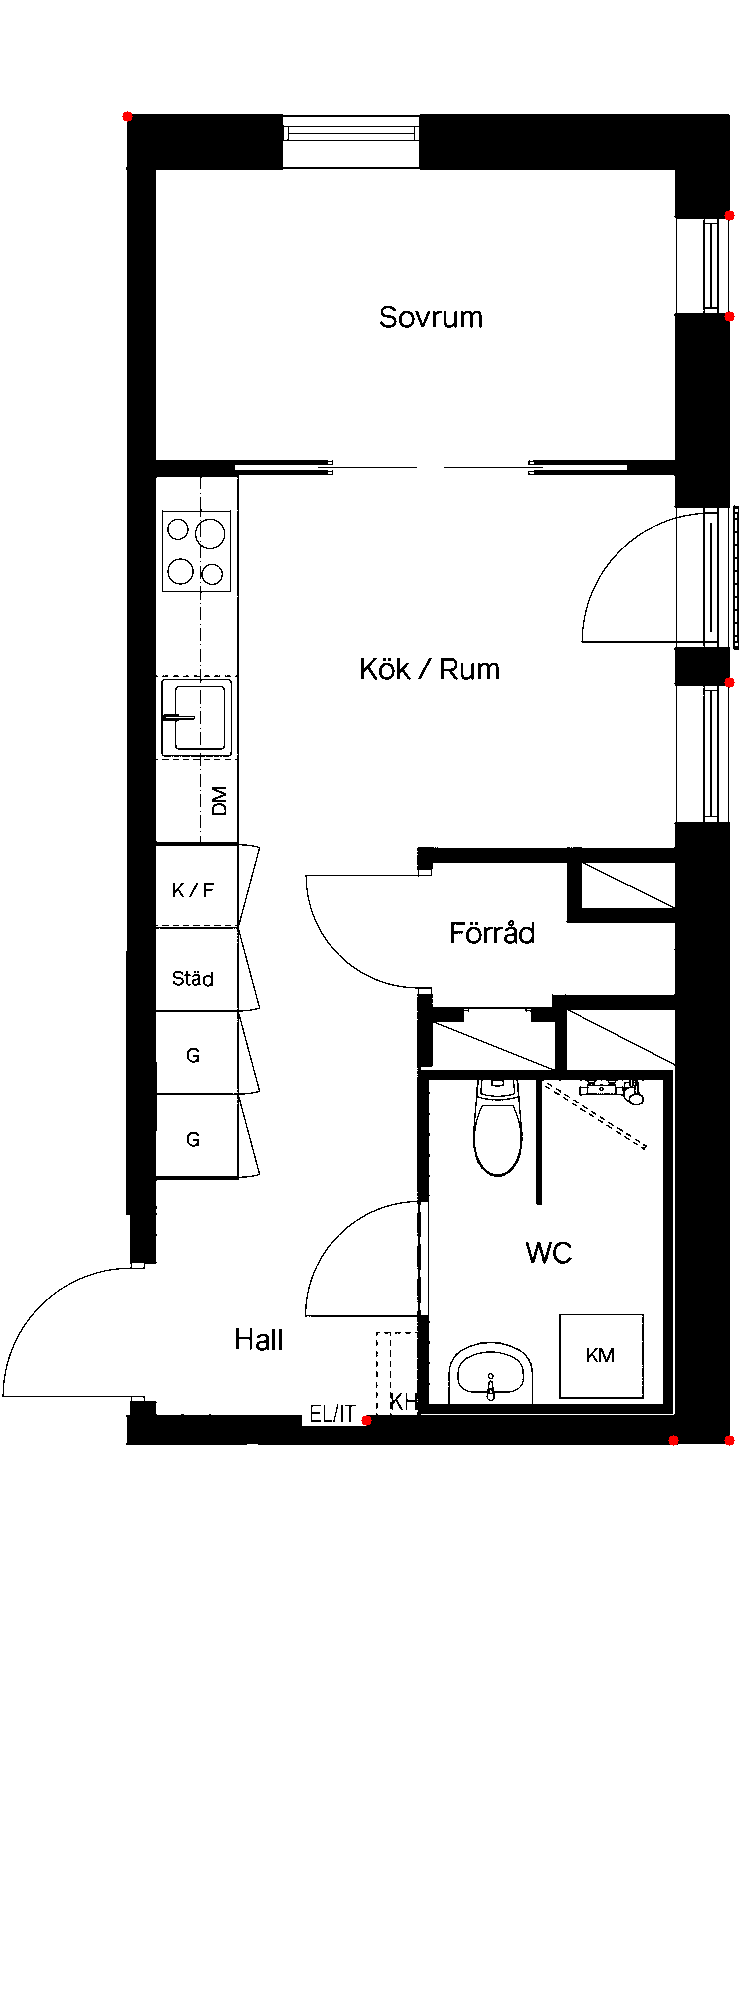

In [24]:
# Iterate over every outer contour and every inner contour to compute intersections.
intersections = []
for cnt_outer in outer_contours:
    outer_segments = get_segments_from_contour(cnt_outer)
    for cnt_inner in inner_contours:
        inner_segments = get_segments_from_contour(cnt_inner)
        for seg_out in outer_segments:
            for seg_in in inner_segments:
                pt = line_intersection(seg_out[0], seg_out[1], seg_in[0], seg_in[1])
                if pt is not None:
                    intersections.append(pt)

# Remove duplicate intersection points using a tolerance.
unique_intersections = remove_duplicate_points(intersections, tol=5)

# Visualize the intersection points on a copy of the original image.
vis_img = thresh1.copy()
for pt in unique_intersections:
    cv2.circle(vis_img, (int(pt[0]), int(pt[1])), 5, (0, 0, 255), -1)
cv2_imshow(vis_img)

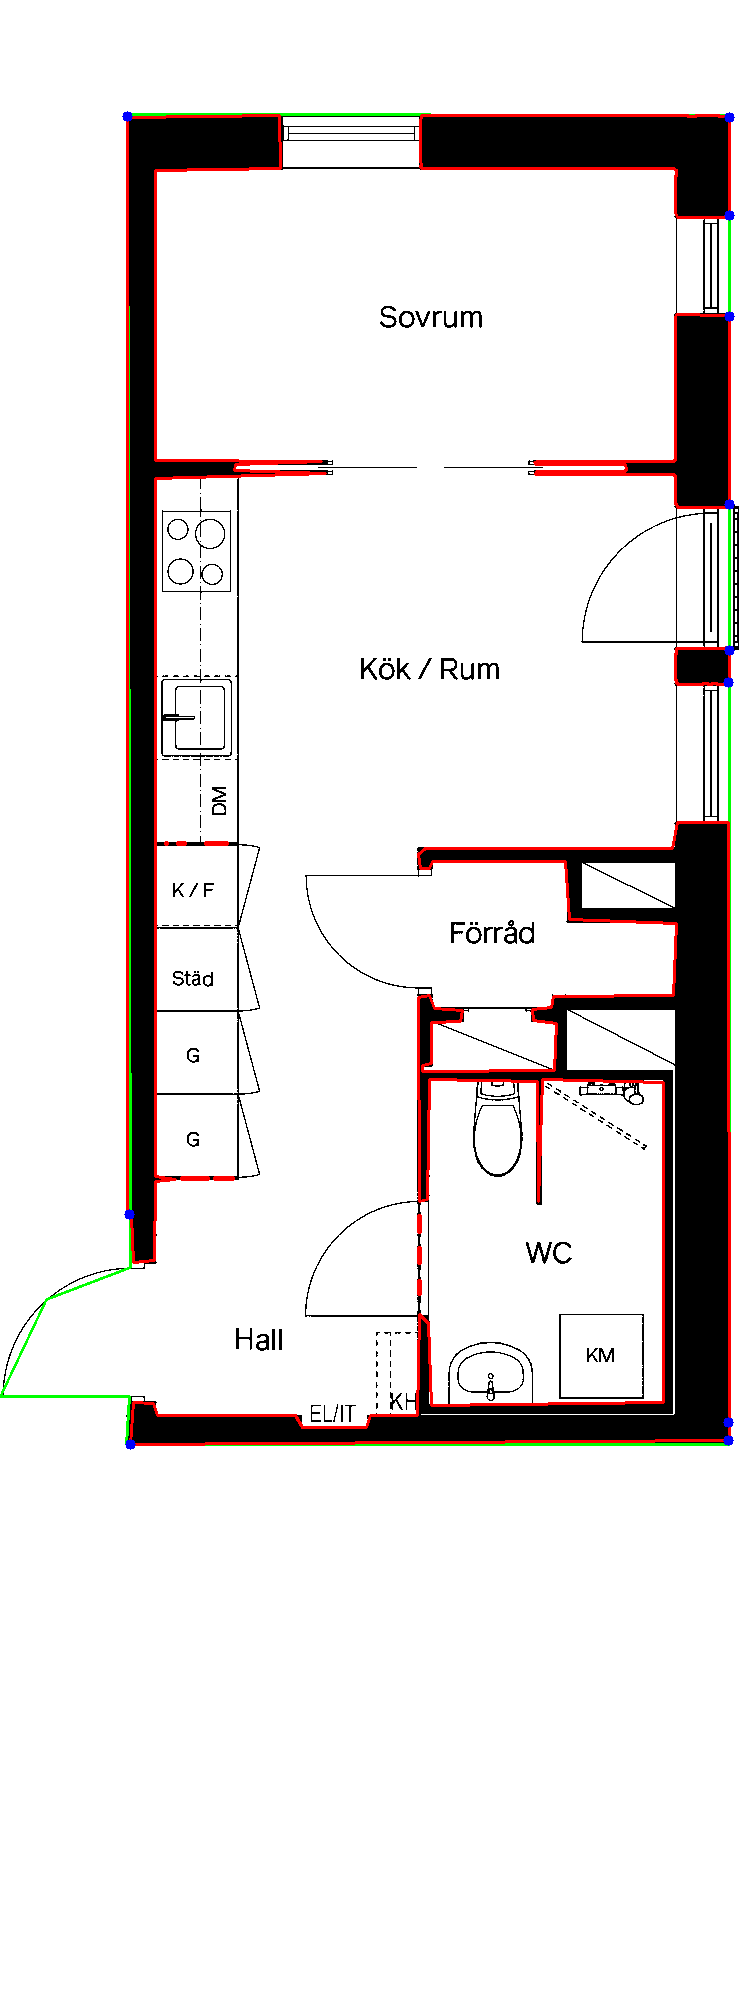

In [25]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def get_segments_from_contour(contour, epsilon_factor=0.005):
    """
    Approximate the contour with a polygon and return a list of line segments.
    A smaller epsilon_factor retains more detail.
    """
    arc_len = cv2.arcLength(contour, True)
    epsilon = epsilon_factor * arc_len
    approx = cv2.approxPolyDP(contour, epsilon, True)
    segments = []
    for i in range(len(approx)):
        p1 = tuple(approx[i][0])
        p2 = tuple(approx[(i+1) % len(approx)][0])
        segments.append((p1, p2))
    return segments

def line_intersection(p1, p2, p3, p4):
    """
    Compute the intersection point (if any) between two line segments: p1-p2 and p3-p4.
    Returns (x, y) if they intersect; otherwise, returns None.
    """
    x1, y1 = p1; x2, y2 = p2
    x3, y3 = p3; x4, y4 = p4

    denom = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denom == 0:
        return None  # Lines are parallel

    t = ((x1 - x3) * (y3 - y4) - (y1 - y3) * (x3 - x4)) / denom
    u = -((x1 - x2) * (y1 - y3) - (y1 - y2) * (x1 - x3)) / denom

    if 0 <= t <= 1 and 0 <= u <= 1:
        inter_x = x1 + t * (x2 - x1)
        inter_y = y1 + t * (y2 - y1)
        return (inter_x, inter_y)
    return None

def remove_duplicate_points(points, tol=5):
    """
    Remove points that are within 'tol' pixels of each other.
    """
    unique = []
    for pt in points:
        if not any(np.linalg.norm(np.array(pt) - np.array(q)) < tol for q in unique):
            unique.append(pt)
    return unique

# --- ASSUMPTION ---
# outer_contours and inner_contours are already computed from your earlier processing steps.
# thresh1 is your original thresholded image.

# Create a copy of thresh1 for drawing.
result_img = thresh1.copy()

# ----------------------
# 1. Draw Outer Segments (Green)
# ----------------------
for cnt in outer_contours:
    segments = get_segments_from_contour(cnt, epsilon_factor=0.005)
    for seg in segments:
        cv2.line(result_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 255, 0), 2)

# ----------------------
# 2. Draw Inner Segments (Red)
# ----------------------
for cnt in inner_contours:
    segments = get_segments_from_contour(cnt, epsilon_factor=0.001)
    for seg in segments:
        cv2.line(result_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 0, 255), 2)

# ----------------------
# 3. Compute and Draw Intersection Points (Blue)
# ----------------------
intersections = []
for cnt_outer in outer_contours:
    outer_segments = get_segments_from_contour(cnt_outer, epsilon_factor=0.001)
    for cnt_inner in inner_contours:
        inner_segments = get_segments_from_contour(cnt_inner, epsilon_factor=0.001)
        for seg_out in outer_segments:
            for seg_in in inner_segments:
                pt = line_intersection(seg_out[0], seg_out[1], seg_in[0], seg_in[1])
                if pt is not None:
                    intersections.append(pt)

# Remove duplicate intersection points.
unique_intersections = remove_duplicate_points(intersections, tol=5)

# Draw the intersection points as blue circles.
for pt in unique_intersections:
    cv2.circle(result_img, (int(pt[0]), int(pt[1])), 5, (255, 0, 0), -1)

# Display the final overlay image.
cv2_imshow(result_img)


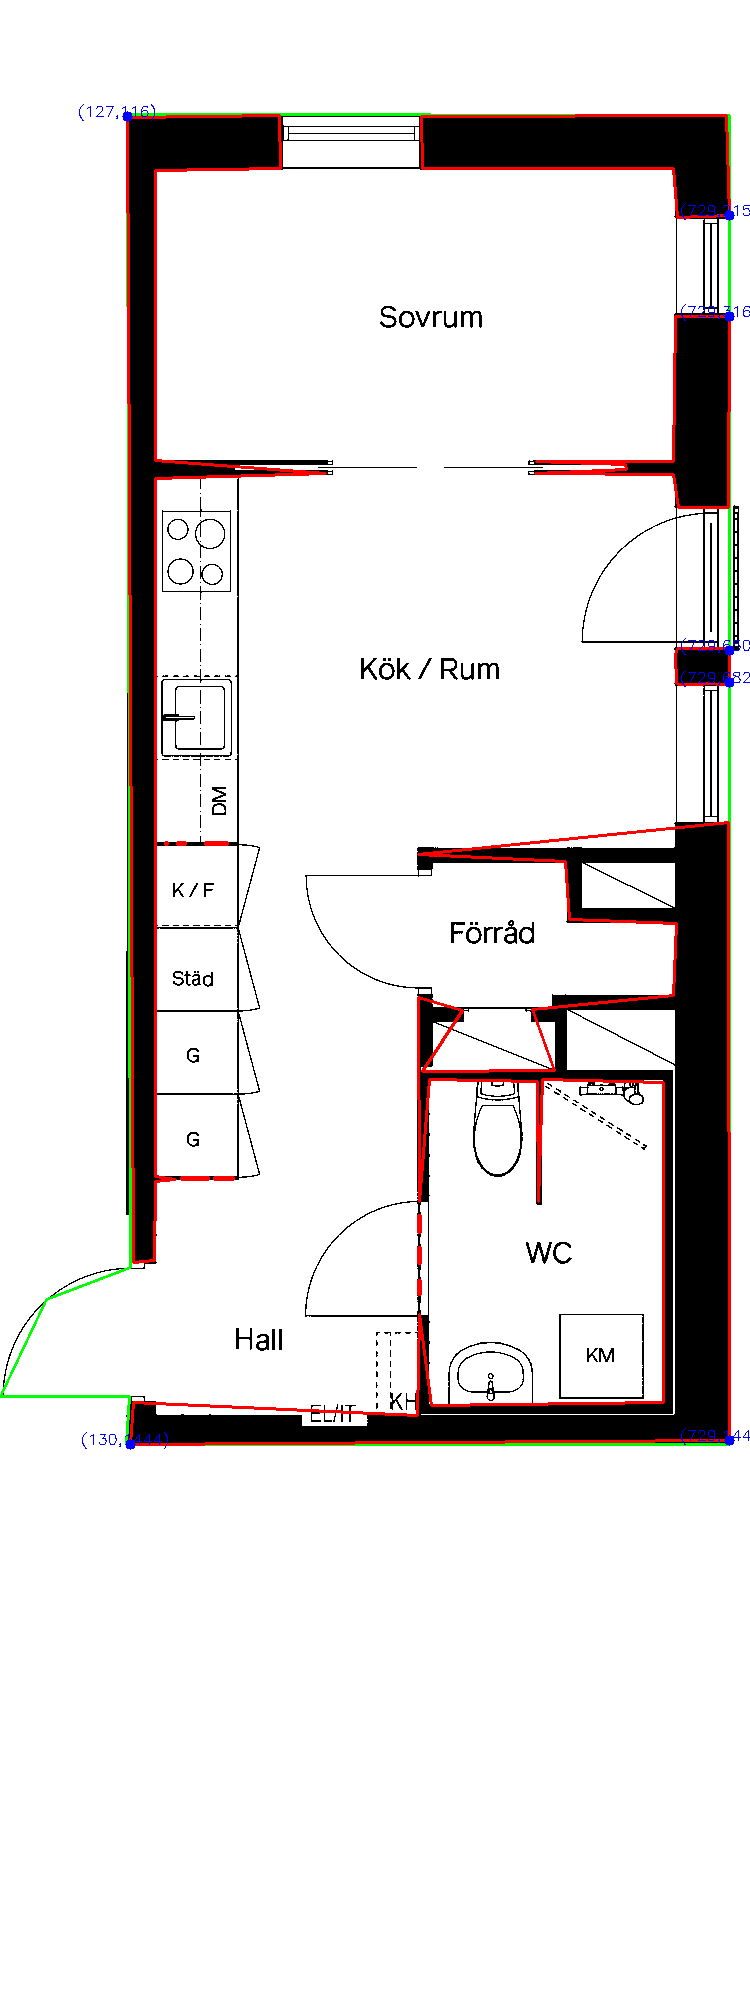

Intersection Points: [(130.0, 1444.0), (729.0, 1440.0), (729.0, 682.0), (729.0, 650.0), (729.0, 316.0), (729.0, 215.0), (127.00780545697299, 116.99989729661877)]


In [26]:
# Create an overlay image from thresh1
overlay_img = thresh1.copy()

# Draw outer segments (Green)
for cnt in outer_contours:
    segments = get_segments_from_contour(cnt, epsilon_factor=0.005)
    for seg in segments:
        cv2.line(overlay_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 255, 0), 2)

# Draw inner segments (Red)
for cnt in inner_contours:
    segments = get_segments_from_contour(cnt, epsilon_factor=0.005)
    for seg in segments:
        cv2.line(overlay_img,
                 (int(seg[0][0]), int(seg[0][1])),
                 (int(seg[1][0]), int(seg[1][1])),
                 (0, 0, 255), 2)

# Compute intersections between outer and inner segments.
intersections = []
for cnt_outer in outer_contours:
    outer_segments = get_segments_from_contour(cnt_outer, epsilon_factor=0.005)
    for cnt_inner in inner_contours:
        inner_segments = get_segments_from_contour(cnt_inner, epsilon_factor=0.005)
        for seg_out in outer_segments:
            for seg_in in inner_segments:
                pt = line_intersection(seg_out[0], seg_out[1], seg_in[0], seg_in[1])
                if pt is not None:
                    intersections.append(pt)
unique_intersections = remove_duplicate_points(intersections, tol=5)

# Draw intersection points (Blue) and display coordinates to the left.
for pt in unique_intersections:
    x, y = int(pt[0]), int(pt[1])
    cv2.circle(overlay_img, (x, y), 5, (255, 0, 0), -1)
    # Adjust the text position to the left (e.g., x-50)
    cv2.putText(overlay_img, f"({x},{y})", (x - 50, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

# Display the final overlay image using cv2_imshow (Colab-friendly)
from google.colab.patches import cv2_imshow
cv2_imshow(overlay_img)

# Print the list of intersection points.
print("Intersection Points:", unique_intersections)



In [27]:
import cv2
import numpy as np

# --- Assume unique_intersections is already defined ---
# For interactive editing, copy the intersections into an editable list.
points = unique_intersections.copy()

# Global variables for interactivity.
selected_index = -1
dragging = False

def draw_interactive_points(img, pts, selected_idx):
    """Draw points and their coordinates on the image."""
    for i, pt in enumerate(pts):
        x, y = int(pt[0]), int(pt[1])
        # Yellow for normal points; purple for selected point.
        color = (0, 255, 255) if i != selected_idx else (255, 0, 255)
        cv2.circle(img, (x, y), 5, color, -1)
        # Draw the coordinate text to the left of the point.
        cv2.putText(img, f"({x},{y})", (x - 50, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

def interactive_mouse_callback(event, x, y, flags, param):
    global points, selected_index, dragging
    if event == cv2.EVENT_LBUTTONDOWN:
        # Check if clicking near an existing point.
        found = False
        for i, pt in enumerate(points):
            if np.linalg.norm(np.array([x, y]) - np.array(pt)) < 10:
                selected_index = i
                dragging = True
                found = True
                break
        if not found:
            # Add a new point if not near any existing point.
            points.append((x, y))
            selected_index = -1

    elif event == cv2.EVENT_MOUSEMOVE:
        if dragging and selected_index != -1:
            points[selected_index] = (x, y)

    elif event == cv2.EVENT_LBUTTONUP:
        dragging = False
        selected_index = -1

    elif event == cv2.EVENT_RBUTTONDOWN:
        # Delete a point if right-click is near it.
        for i, pt in enumerate(points):
            if np.linalg.norm(np.array([x, y]) - np.array(pt)) < 10:
                del points[i]



In [29]:
# --- Export Points to JSON ---
import json
# Convert each point to a dictionary with 'x' and 'y' keys.
json_points = [{"x": int(pt[0]), "y": int(pt[1])} for pt in unique_intersections]
with open("openings.json", "w") as f:
    json.dump(json_points, f, indent=4)
print("Exported JSON file 'openings.json' with the following data:")
print(json_points)

Exported JSON file 'openings.json' with the following data:
[{'x': 130, 'y': 1444}, {'x': 729, 'y': 1440}, {'x': 729, 'y': 682}, {'x': 729, 'y': 650}, {'x': 729, 'y': 316}, {'x': 729, 'y': 215}, {'x': 127, 'y': 116}]
